# Boston Marathon Clustering

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline

from IPython.display import display
pd.options.display.max_columns = None

from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get data
df = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv', 
                 error_bad_lines=False)

print(df.shape)
print(df.head())

(31984, 21)
     10k                name  division    25k gender  age  official bib  \
0  17.37  Yamamoto, Hiroyuki         8  47.67      M   47     85.25  W1   
1  32.58        Jeptoo, Rita         1  82.43      F   33    138.95  F1   
2  16.62   Van Dyk, Ernst F.         1  45.80      M   41     80.60  W2   
3  32.57        Dibaba, Mare         3  82.43      F   24    140.58  F2   
4  17.12      Hokinoue, Kota         2  46.37      M   40     81.23  W3   

   genderdiv  ctz     35k  overall  pace state    30k     5k   half    20k  \
0          8  NaN   71.40        8  3.27   NaN  59.18   8.02  39.72  37.65   
1          1  NaN  116.37       21  5.30   NaN  99.33  16.22  69.47  65.83   
2          1  NaN   67.42        1  3.08   NaN  56.45   7.75  38.03  36.10   
3          3  NaN  116.37       27  5.37   NaN  99.33  16.20  69.47  65.83   
4          2  NaN   67.83        2  3.10   NaN  57.03   8.02  38.60  36.58   

  country            city     40k  
0     JPN         Fukuoka   80.4

In [3]:
# Replace - with 0
#print(df.isin(['-']).sum())
df = df.replace(to_replace='-', value=0)

In [4]:
# turn gender in to binary
df['gender'] = np.where(df.gender=='M', 1, 0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null float64
name         31984 non-null object
division     31984 non-null float64
25k          31984 non-null float64
gender       31984 non-null float64
age          31984 non-null float64
official     31984 non-null float64
bib          31984 non-null category
genderdiv    31984 non-null float64
ctz          1244 non-null category
35k          31984 non-null float64
overall      31984 non-null float64
pace         31984 non-null float64
state        29408 non-null category
30k          31984 non-null float64
5k           31984 non-null float64
half         31984 non-null float64
20k          31984 non-null float64
country      31984 non-null category
city         31983 non-null category
40k          31984 non-null float64
dtypes: category(5), float64(15), object(1)
memory usage: 5.8+ MB
None


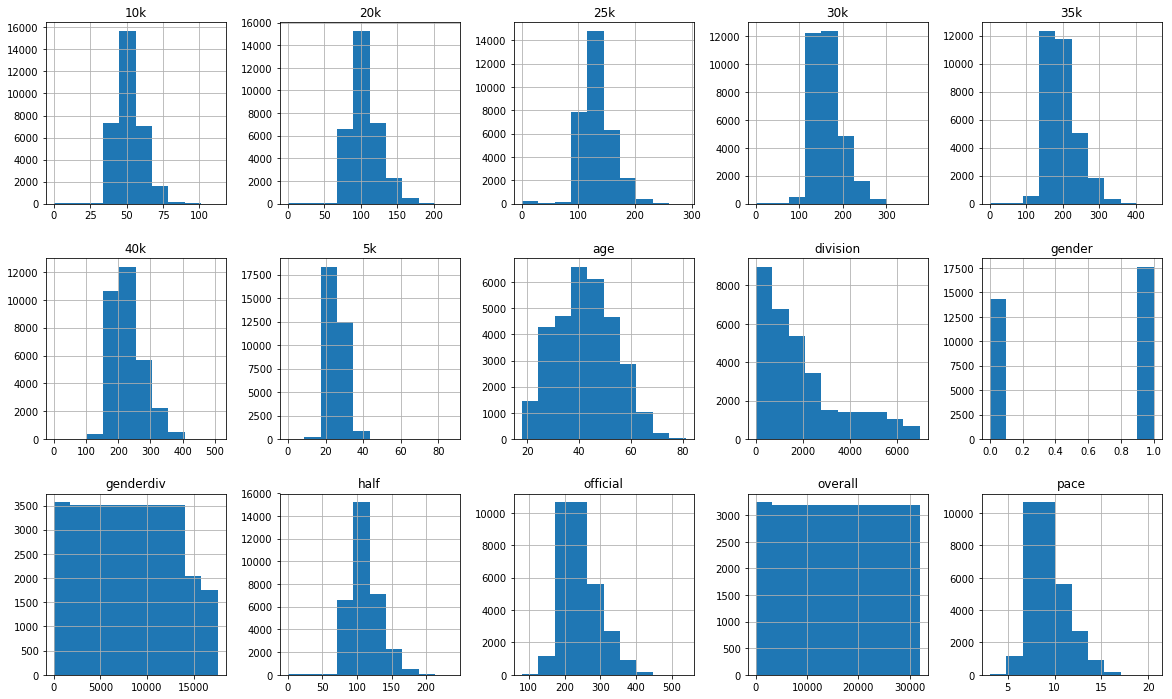

In [5]:
# Fix variables that should be floats
non_float = ['name', 'bib', 'ctz', 'state', 'city', 'country']
floats = df.columns[~df.columns.isin(non_float)]
for x in floats:
    df[x] = df[x].astype('float')
    
non_cats = ['name']
categories = [x for x in non_float if x not in non_cats]

for x in categories:
    df[x] = df[x].astype('category')
print(df.info())
df.hist(figsize=(20,12), layout=(3,5))
plt.show()

In [6]:
# Try selecting overall as outcome and running a KMeans cluster
# Start with only the float variables - we can come back and add dummies for categorical later

X = df.select_dtypes('float').drop('overall',1)
y = df.overall

# Normalize
X_norm = normalize(X)

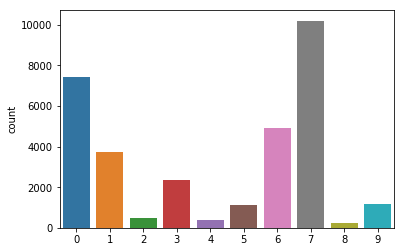

8.220495291713529e-07

In [7]:
y_pred = KMeans(n_clusters=10, random_state=42).fit_predict(X_norm)
sns.countplot(y_pred)
plt.show()
metrics.adjusted_rand_score(y, y_pred)

Looks like there is an imbalance between clusers. After trying many different cluster sizes, they all are fitting with almost perfect randomness. Let's make bins to see if we can make the clusters fit a little nicer.

In [8]:
df1 = df.copy()

ari = []
for x in range(1, 101):
    # Even sized bins for overall
    df1['bins'] = pd.cut(df.overall, x)
    values = df1.bins.value_counts().sort_values().index.tolist()

    for i in range(len(df1.bins.unique())):
        df1.loc[(df['overall']>=values[i].left) & (df1['overall']<values[i].right), 'nbins'] = (i+1)
    
    n = len(df1.bins.unique())

    #y_pred_bins = KMeans(n_clusters=n, random_state=42).fit_predict(X_norm)
    minibatchkmeans = MiniBatchKMeans(init='random', n_clusters=n, batch_size=200)
    ybins = minibatchkmeans.fit_predict(X_norm)
    ari.append(metrics.adjusted_rand_score(df1['nbins'], ybins))

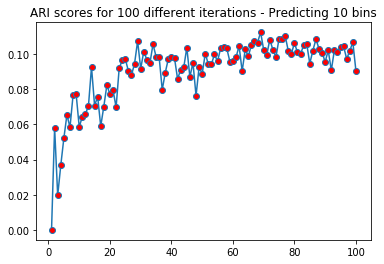

In [26]:
plt.plot(range(1,101), ari, marker='o', markerfacecolor='r')
plt.title("ARI scores for 100 different iterations - Predicting 10 bins")
plt.show()

Doing a little better now.  I think the issue I am running into is trying to predict a continuous variable.  The more clusters the closer I should get to predicting the continuous variable.  In other words I do not think I am using the ARI appropriately, nor do I think I should be trying to predict the overall variable.  I will start investigating clustering techniques and evaluating them using the silhouette coefficient.

## Return to original full data set
## K-Means

In [10]:
# Normalize the full dataset
df_norm = pd.DataFrame(normalize(df.select_dtypes('float')), columns=df.select_dtypes('float').columns)


# Sample down to save time
df_small = df_norm.sample(frac=.1, random_state=42)

# get inertias for some clusters on the small dataset
inertias = []
for i in range(1, 51):
    fit = KMeans(n_clusters=i, random_state=42).fit(df_small)
    inertias.append(fit.inertia_)

In [11]:
# Measure the silhouette coefficient
silhouette = []
for i in range(2, 51):
    model = KMeans(n_clusters=i, random_state=42).fit(df_small)
    labels_km = model.labels_
    silhouette.append(metrics.silhouette_score(df_small, labels_km, metric='euclidean'))
        
xmax = np.argmax(silhouette)+2
ymax = max(silhouette)
text = 'clusters: {:d}, silhouette score: {:0.5f}'.format(xmax, ymax)

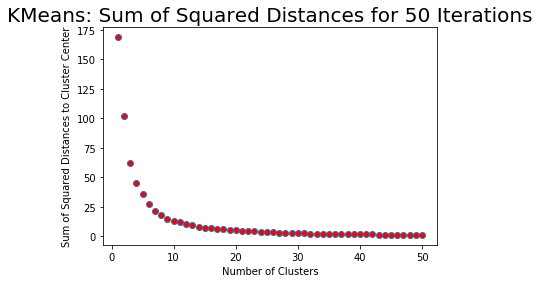

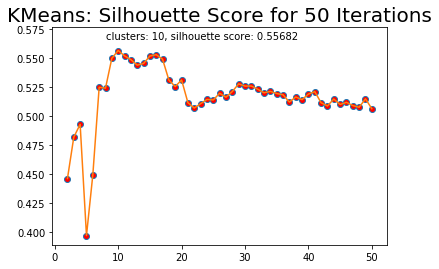

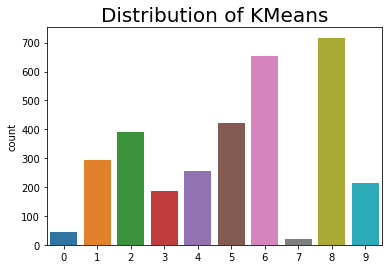

In [12]:
# plot sum of squared distances to center of cluster
plt.plot(range(1,51), inertias, 'o', markerfacecolor='r')
plt.title('KMeans: Sum of Squared Distances for 50 Iterations', fontsize=20)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances to Cluster Center', rotation=90)
plt.show()

    
# plot silhouette scores
fig, ax = plt.subplots(1)
plt.plot(range(2,51), silhouette, 'o', markerfacecolor='r')
plt.plot(range(2,51), silhouette)
ax.set_ylim(None,ymax+0.02)
ax.annotate(text, xy=(np.argmax(silhouette), ymax+0.01))
plt.title('KMeans: Silhouette Score for 50 Iterations', fontsize=20)
plt.show()

# countplot to show distribution
sns.countplot(KMeans(n_clusters=xmax, random_state=42).fit_predict(df_small))
plt.title('Distribution of KMeans', fontsize=20)
plt.show()


From the silhouette score we can see that the best and inertia plot we can see that a cluster of 13 will minimize the sum of squared distances from the center of the cluster and also score the highest on the silhouette score metric, telling us we have very similar clusters.  The distribution, though, is telling us that our clusters are not the same size, which is a problem for the KMeans.

## Mean Shift

Bandwidth Estimate:  0.31248310578478644
Number of estimated clusters: 2


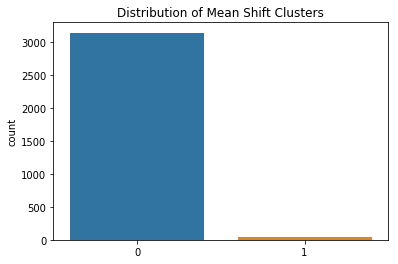

Silhouette Score for Mean-Shift:
0.6767315577933342
Number of estimated clusters for low bandwidth: 9


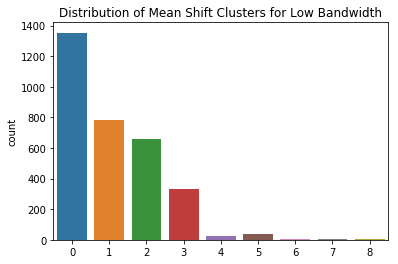

Silhouette Score for Mean-Shift with low bandwidth:
0.43970954460421446
Number of estimated clusters for default: 4


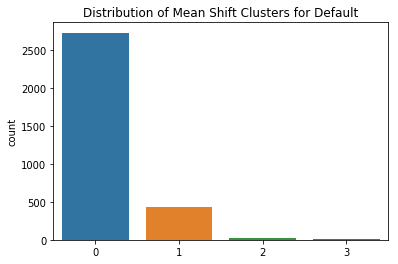

Silhouette Score for Mean-Shift with default:
0.48810386221096336


In [24]:
bandwidth = estimate_bandwidth(df_small, quantile=0.7)
print("Bandwidth Estimate: ",bandwidth)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
ms.fit(df_small)
labels_ms = ms.labels_

# Count our clusters.
n_clusters_ = len(np.unique(labels_ms))
print("Number of estimated clusters: {}".format(n_clusters_))

sns.countplot(labels_ms)
plt.title("Distribution of Mean Shift Clusters")
plt.show()

# Score
print('Silhouette Score for Mean-Shift:')
print(metrics.silhouette_score(df_small, labels_ms, metric='euclidean'))
print('='*50)

# low bandwidth
ms_low = MeanShift(bandwidth=0.1, bin_seeding=True, cluster_all=True)
ms_low.fit(df_small)
lowlabels_ms = ms_low.labels_

# Count our clusters.
n_clusters_low = len(np.unique(lowlabels_ms))
print("Number of estimated clusters for low bandwidth: {}".format(n_clusters_low))

# plot
sns.countplot(lowlabels_ms)
plt.title("Distribution of Mean Shift Clusters for Low Bandwidth")
plt.show()

# Calculate the silhouette score
print('Silhouette Score for Mean-Shift with low bandwidth:')
print(metrics.silhouette_score(df_small, lowlabels_ms, metric='euclidean'))
print('='*50)

# default
ms_d = MeanShift(bin_seeding=True)
ms_d.fit(df_small)
dlabels_ms = ms_d.labels_

# Count our clusters.
n_clusters_d = len(np.unique(dlabels_ms))
print("Number of estimated clusters for default: {}".format(n_clusters_d))

# plot
sns.countplot(dlabels_ms)
plt.title("Distribution of Mean Shift Clusters for Default")
plt.show()

# Calculate the silhouette score
print('Silhouette Score for Mean-Shift with default:')
print(metrics.silhouette_score(df_small, dlabels_ms, metric='euclidean'))

This silhouette score increases with the quantile value because the number of clusters goes down.  If the quantile is set to 1 all the data clusters to one.  By increasing the bandwidth parameter we can increase the smoothing for the density surface, thus creating less clusters.  With a bandwidth of 0.1 we see that we have 9 clusters, but 4 of them seem to have the majority of the data.  With the default settings we are getting only 4 clusters, but not evenly distributed. The Mean-shift with two clusters has very strong similarity within each cluster.  The fact that the clusters are not the same size is not an issue for mean-shift.

## Spectral Clustering

In [14]:
# Measure the silhouette coefficient with RBF (euclidean distance) - this is very slow so don't make range too large
silhouette_sc = []
for i in range(2, 10):
    model = SpectralClustering(n_clusters=i, random_state=42).fit(df_small)
    labels_sc = model.labels_
    silhouette_sc.append(metrics.silhouette_score(df_small, labels_sc, metric='euclidean'))
        
xmaxsc = np.argmax(silhouette_sc)+2
ymaxsc = max(silhouette_sc)
textsc = 'clusters: {:d}, silhouette score: {:0.5f}'.format(xmaxsc, ymaxsc)

In [15]:
# Measure the silhouette coefficient with KNN - default is 10 neighbors
silhouette_scKNN = []
for i in range(2, 10):
    model = SpectralClustering(n_clusters=i, random_state=42, affinity='nearest_neighbors').fit(df_small)
    labels_scKNN = model.labels_
    silhouette_scKNN.append(metrics.silhouette_score(df_small, labels_scKNN, metric='euclidean'))
        
xmaxscKNN = np.argmax(silhouette_scKNN)+2
ymaxscKNN = max(silhouette_scKNN)
textscKNN = 'clusters: {:d}, silhouette score: {:0.5f}'.format(xmaxscKNN, ymaxscKNN)

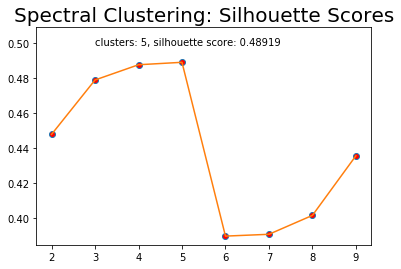

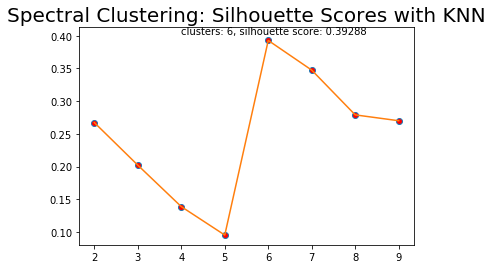

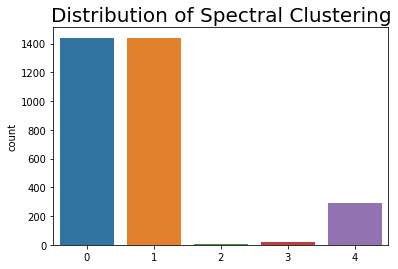

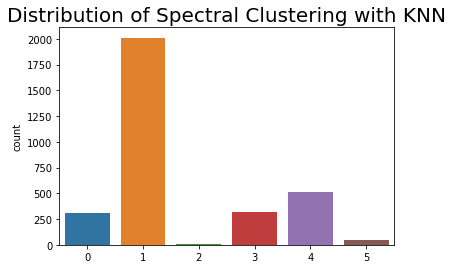

In [16]:
# plot silhouette scores
fig, ax = plt.subplots(1)
plt.plot(range(2,10), silhouette_sc, 'o', markerfacecolor='r')
plt.plot(range(2,10), silhouette_sc)
ax.set_ylim(None,ymaxsc+0.02)
ax.annotate(textsc, xy=(np.argmax(silhouette_sc), ymaxsc+0.01))
plt.title('Spectral Clustering: Silhouette Scores', fontsize=20)
plt.show()

fig, ax = plt.subplots(1)
plt.plot(range(2,10), silhouette_scKNN, 'o', markerfacecolor='r')
plt.plot(range(2,10), silhouette_scKNN)
ax.set_ylim(None,ymaxscKNN+0.02)
ax.annotate(textscKNN, xy=(np.argmax(silhouette_scKNN), ymaxscKNN+0.01))
plt.title('Spectral Clustering: Silhouette Scores with KNN', fontsize=20)
plt.show()

# countplot to show distribution
sns.countplot(SpectralClustering(n_clusters=xmaxsc, random_state=42).fit_predict(df_small))
plt.title('Distribution of Spectral Clustering', fontsize=20)
plt.show()

sns.countplot(SpectralClustering(n_clusters=xmaxscKNN, random_state=42).fit_predict(df_small))
plt.title('Distribution of Spectral Clustering with KNN', fontsize=20)
plt.show()

The spectral clustering gave the best silhouette score with 5 clusters and the rbf kernel.  The distribution is showing that they are not even which is not an issue for spectral clustering.

## Affinity Propagation

In [17]:
# Initialize affinity propagation
af = AffinityPropagation(damping=0.8, 
                         max_iter=200, 
                         convergence_iter=15, 
                         copy=True, 
                         preference=None, 
                         affinity='euclidean', 
                         verbose=False)
# Fit af
af.fit(df_small)

# Pull the number of clusters and cluster assignments for each data point.
num_clusters = len(af.cluster_centers_indices_)
print('Estimated number of clusters for Affinity Propagation: {}'.format(num_clusters))

Estimated number of clusters for Affinity Propagation: 49


In [18]:
# Measure the silhouette coefficient changing the damping
silhouette_af = []
damps = np.linspace(0.5, 0.9, 5)
for i in damps:
    model = AffinityPropagation(damping=i).fit(df_small)
    labels_af = model.labels_
    silhouette_af.append(metrics.silhouette_score(df_small, labels_af, metric='euclidean'))
    
    # Pull the number of clusters and count.
    num_clusters = len(model.cluster_centers_indices_)
    print('Estimated number of clusters for Affinity Propagation with damping={}: {}'.format(i,num_clusters))
    print('-'*50)

Estimated number of clusters for Affinity Propagation with damping=0.5: 2166
--------------------------------------------------
Estimated number of clusters for Affinity Propagation with damping=0.6: 1006
--------------------------------------------------
Estimated number of clusters for Affinity Propagation with damping=0.7: 186
--------------------------------------------------
Estimated number of clusters for Affinity Propagation with damping=0.8: 49
--------------------------------------------------
Estimated number of clusters for Affinity Propagation with damping=0.9: 47
--------------------------------------------------


In [19]:
xmaxaf = damps[np.argmax(silhouette_af)]
ymaxaf = max(silhouette_af)
textaf = 'damping: {:0.2f}, silhouette score: {:0.5f}'.format(xmaxaf, ymaxaf)
print(textaf)

damping: 0.90, silhouette score: 0.51517


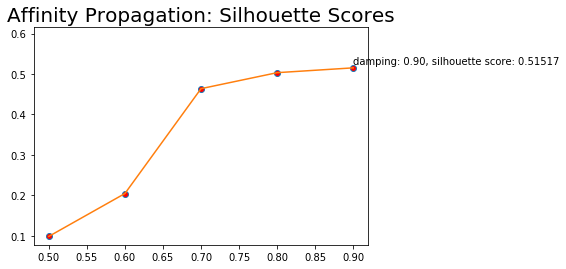

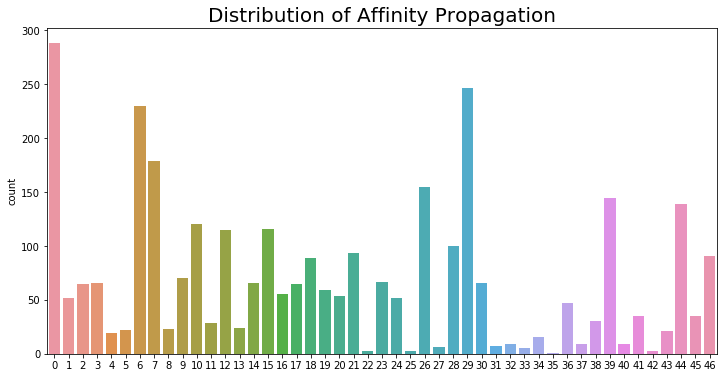

In [20]:
# silhouette plot
fig, ax = plt.subplots(1, figsize=(6,4))
plt.plot(np.linspace(0.5, 0.9, 5), silhouette_af, 'o', markerfacecolor='r')
plt.plot(np.linspace(0.5, 0.9, 5), silhouette_af)
ax.set_ylim(None,ymaxaf+0.1)
#ax.set_xlim(None, 1)
ax.annotate(textaf, xy=(xmaxaf, ymaxaf+0.01))
plt.title('Affinity Propagation: Silhouette Scores', fontsize=20)
plt.show()

damps = np.linspace(0.5, 0.9, 5)

fig = plt.figure(figsize=(12,6))
sns.countplot(AffinityPropagation(damping=xmaxaf).fit_predict(df_small))
plt.title('Distribution of Affinity Propagation', fontsize=20)
plt.show()

for i in damps:
    print()

## Data Story

From the investigation of clustering techniques the final method I will be applying to the boston marathon dataset is the KMeans clustering, based on it having the highest silhouette score.

In [45]:
# cluster the data
print(df_norm.shape)
kmeans_full = KMeans(n_clusters=10, random_state=42).fit(df_norm)

(31984, 15)


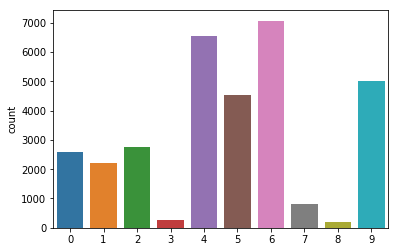

[0 1 2 3 4 5 6 7 8 9]
(31984, 10)
-140.12769244388568


In [60]:
sns.countplot(kmeans_full.labels_)
plt.show()

print(np.unique(kmeans_full.labels_))


xtrans = pd.DataFrame(kmeans_full.transform(df_norm))
print(xtrans.shape)
print(kmeans_full.score(df_norm))

In [59]:
klabel = kmeans_full.labels_
print(klabel.shape)

pred = kmeans_full.predict(df_norm)
print(pred.shape)

print((pred!=klabel).sum())

(31984,)
(31984,)
0


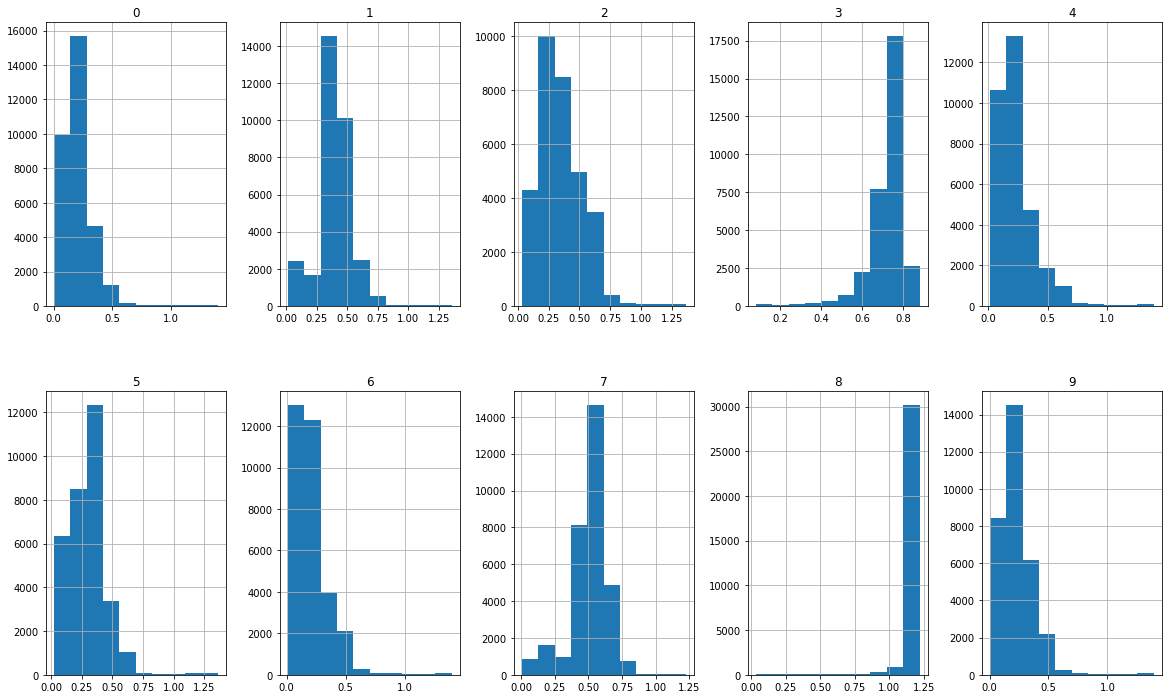

In [65]:
xtrans.hist(figsize=(20,12), layout=(2,5))
plt.show()

In [68]:
# combine transformed data and original data to check for correlation
combo = pd.concat([df_norm, xtrans],1)
print(combo.shape)

(31984, 25)


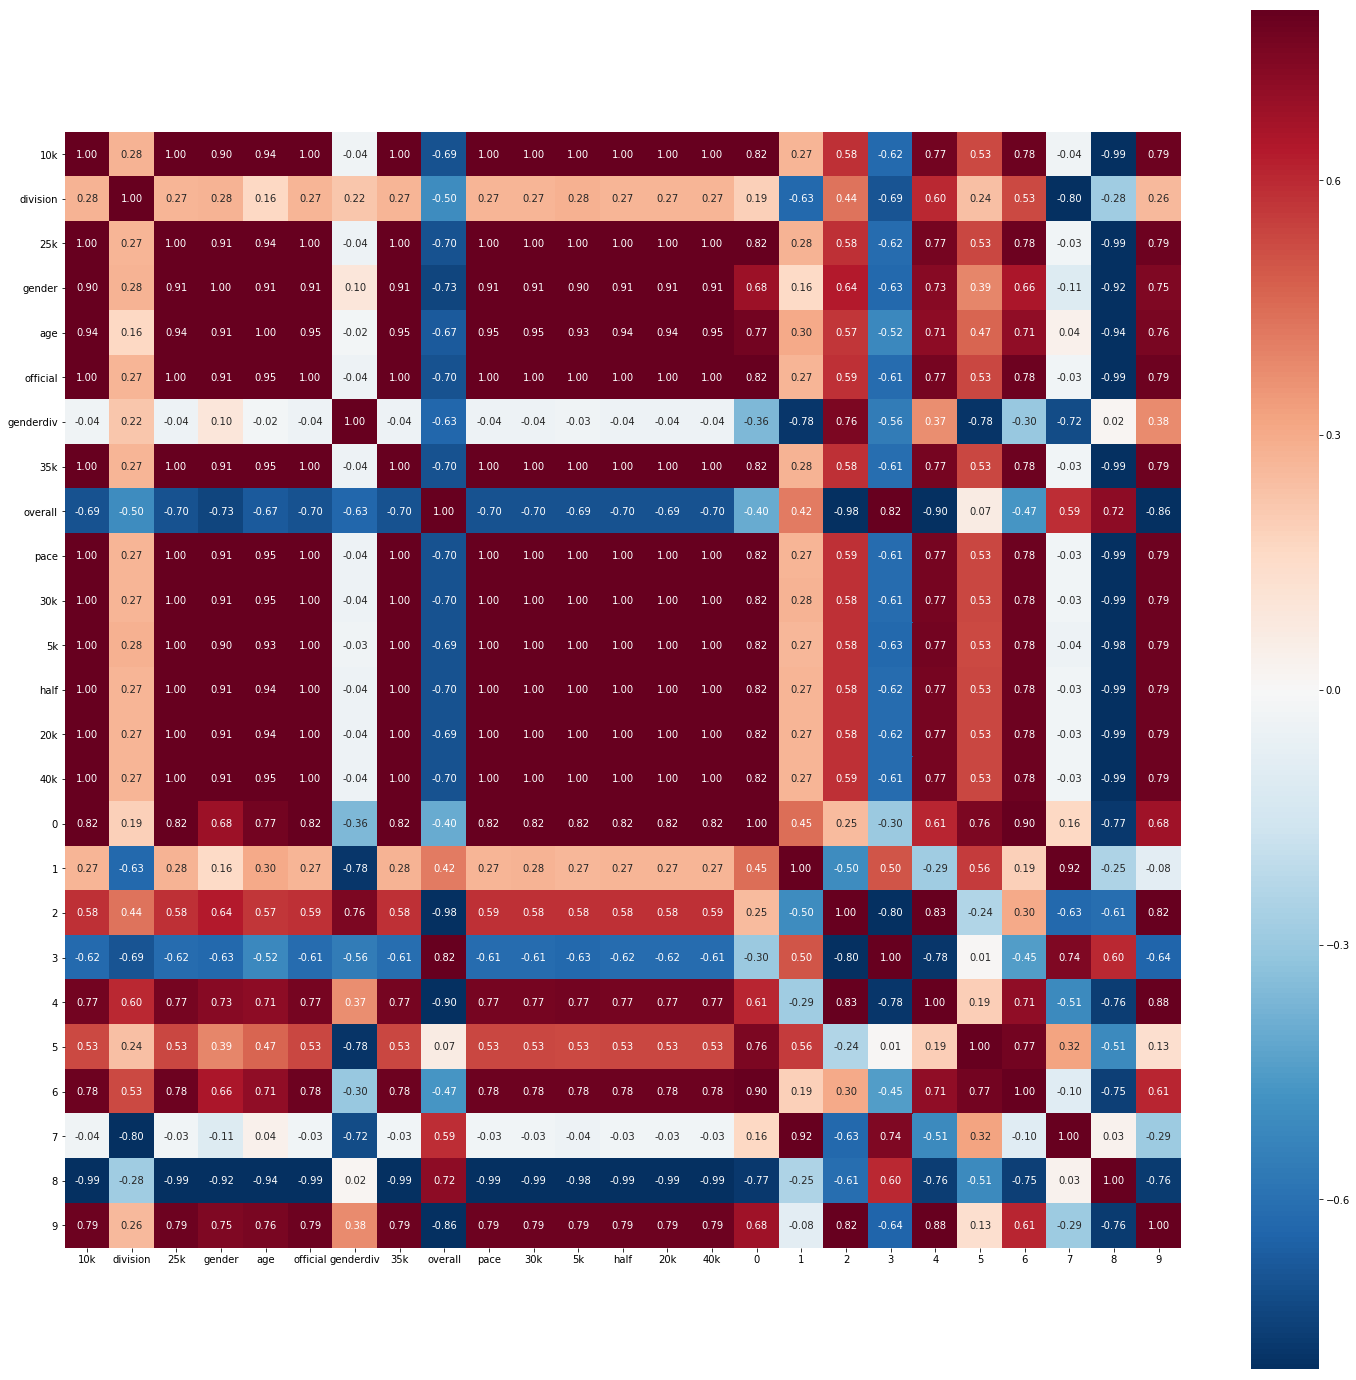

In [70]:
fig = plt.figure(1, figsize=(25,25))
sns.heatmap(combo.corr(), 
            vmin=-0.8, 
            vmax=0.8, 
            square=True, 
            cmap='RdBu_r',
            annot=True,
            fmt='.2f')
plt.show()

I thought I might be able to figure out what each cluster was representing after the transformation with a heatmap, but it doesn't seem to be that clear.  Not exactly sure what story the clusters alone will tell. It seems like because they transform the data into a lower dimension that telling a story from the clusters based on the original data (including visualizations) will not be likely.